# Setup

In [1]:
import math 
from pandas_datareader import data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_fin.stock_info as si

from datetime import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import os
os.chdir(r'D:\Exercise\Prediction')

In [2]:
#Download Equity Data
tickers = 'AMZN'

start_date = datetime(2019,1,1)
end_date = datetime.today()

#Grab Online Data
df = si.get_data(tickers, start_date = start_date, end_date = end_date).reset_index().drop(columns = 'ticker')
df.columns = df.columns.str.capitalize()
df = df.rename(columns ={'Index':'Date'})
df

,Date,Open,High,Low,Close,Adjclose,Volume
0,2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100
1,2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600
2,2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600
3,2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200
4,2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400
...,...,...,...,...,...,...,...
641,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700
642,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000
643,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400
644,2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,3656.639893,2430700


# Exploratory Data Analysis

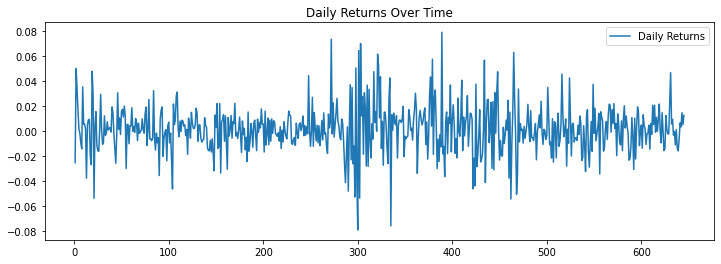

In [3]:
#Calcuate Return
df['Return'] = (df['Close'].pct_change())

#Calcuate Violatility
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

In [4]:
#Check Positive and Negative Return Days
print('Positive Return Day:', df[df.Return > 0]['Close'].count())
#Check Positive and Negative Return Days
print('Unchanged Day:', df[df.Return == 0]['Close'].count())
#Check Positive and Negative Return Days
print('Negative Return Day:', df[df.Return < 0]['Close'].count())
#Percentage of Positive Return
print('Percentage of Postitive Return:', df[df.Return > 0]['Close'].count()/ len(df))

Positive Return Day: 352
Unchanged Day: 0
Negative Return Day: 293
Percentage of Postitive Return: 0.544891640866873


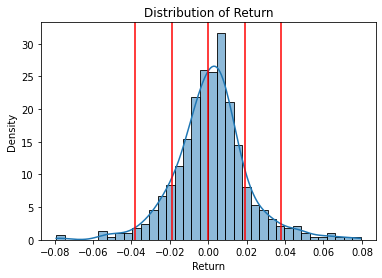

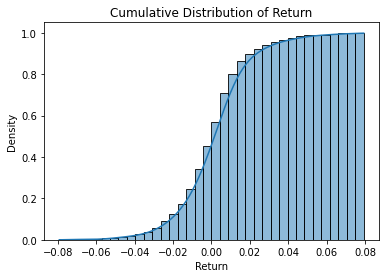

In [5]:
#SD and Percentile
stand_devt = df.Return.std()

#Check Distribution
sns.histplot(data=df, x="Return",stat = 'density', kde=True)
plt.axvline(0,color = 'Red')
plt.axvline(stand_devt,color = 'Red')
plt.axvline(-stand_devt,color = 'Red')
plt.axvline(stand_devt*2,color = 'Red')
plt.axvline(-stand_devt*2,color = 'Red')
plt.title('Distribution of Return')
plt.show()

# Cumculative Distribution
sns.histplot(data=df, x="Return",stat = 'density', cumulative = True, kde=True)
plt.title('Cumulative Distribution of Return')
plt.show()

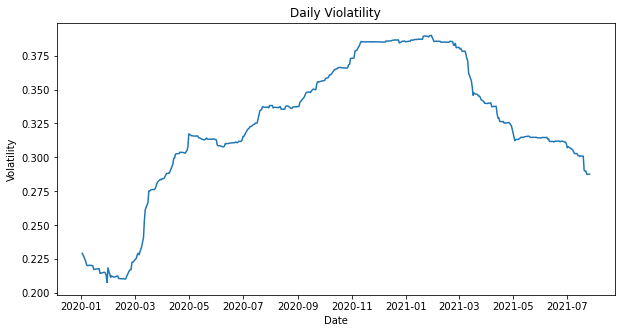

In [6]:
# Annual Violatility
df['Volatility'] = df.Return.rolling(window=252).std()*np.sqrt(252)

plt.figure(figsize=(10, 5))
sns.lineplot(data = df,x = 'Date', y= 'Volatility')
plt.title('Daily Violatility')
plt.show()

In [7]:
df

,Date,Open,High,Low,Close,Adjclose,Volume,Return,Volatility
0,2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100,NaN,NaN
1,2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600,-0.025242,NaN
2,2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600,0.050064,NaN
3,2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200,0.034353,NaN
4,2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400,0.016612,NaN
...,...,...,...,...,...,...,...,...,...
641,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500
642,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891
643,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400,0.014736,0.289938
644,2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,3656.639893,2430700,0.005115,0.287530


# Fundamentals and Valuation

In [8]:
#Import Past 3 Fundamental Data to Calcuate PE PS Ratio
Income_statment = si.get_income_statement(tickers, yearly = False).transpose().reset_index().fillna(0)
Income_statment = Income_statment[['endDate','ebit','netIncome','totalRevenue','minorityInterest']]
Income_statment

Breakdown,endDate,ebit,netIncome,totalRevenue,minorityInterest
0,2021-03-31,10865000000,8107000000,108518000000,0
1,2020-12-31,6873000000,7222000000,125555000000,0
2,2020-09-30,6194000000,6331000000,96145000000,0
3,2020-06-30,5843000000,5243000000,88912000000,0


In [9]:
Balance_statement = si.get_balance_sheet(tickers, yearly = False).transpose().reset_index().fillna(0)
Balance_statement = Balance_statement[['endDate','commonStock', 'cash','shortLongTermDebt']]
Balance_statement['commonStock'] = Balance_statement['commonStock']*100
Balance_statement

Breakdown,endDate,commonStock,cash,shortLongTermDebt
0,2021-03-31,500000000.0,3.383400e+10,1.156000e+09
1,2020-12-31,500000000.0,4.212200e+10,1.155000e+09
2,2020-09-30,500000000.0,2.993000e+10,1.550000e+08
3,2020-06-30,500000000.0,3.746600e+10,1.154000e+09


In [10]:
Cashflow_statement = si.get_cash_flow("amzn", yearly = False).transpose().reset_index().fillna(0)
Cashflow_statement = Cashflow_statement[['endDate','depreciation']]
Cashflow_statement

Breakdown,endDate,depreciation
0,2021-03-31,7508000000
1,2020-12-31,7618000000
2,2020-09-30,6523000000
3,2020-06-30,5748000000


In [11]:
Combined_Statement = pd.merge(Income_statment, Balance_statement, on ='endDate', how = 'inner')
Combined_Statement = pd.merge(Combined_Statement, Cashflow_statement, on ='endDate', how = 'inner')
Combined_Statement = Combined_Statement.rename(columns = {'endDate':'Date',
                                                          'ebit': 'EBIT',
                                                          'netIncome': 'Earning',
                                                          'totalRevenue': 'Revenue',
                                                          'commonStock': 'Outstanding Shares',
                                                          'cash': 'Cash',
                                                          'shortLongTermDebt': 'Debt',
                                                          'minorityInterest': 'Minority Interest',
                                                          'depreciation': 'Depreciation'
                                                         })
Combined_Statement

Breakdown,Date,EBIT,Earning,Revenue,Minority Interest,Outstanding Shares,Cash,Debt,Depreciation
0,2021-03-31,10865000000,8107000000,108518000000,0,500000000.0,3.383400e+10,1.156000e+09,7508000000
1,2020-12-31,6873000000,7222000000,125555000000,0,500000000.0,4.212200e+10,1.155000e+09,7618000000
2,2020-09-30,6194000000,6331000000,96145000000,0,500000000.0,2.993000e+10,1.550000e+08,6523000000
3,2020-06-30,5843000000,5243000000,88912000000,0,500000000.0,3.746600e+10,1.154000e+09,5748000000


In [12]:
#Convert to a Daily
Daily_Fundamnetals = pd.DataFrame(pd.date_range(min(Combined_Statement.Date), max(Combined_Statement.Date)), columns = ['Date'])
Daily_Fundamnetals = pd.merge(Daily_Fundamnetals, Combined_Statement, on = 'Date', how = 'left')
Daily_Fundamnetals.fillna(method = 'backfill', inplace = True)

In [13]:
Daily_Fundamnetals.columns

Index(['Date', 'EBIT', 'Earning', 'Revenue', 'Minority Interest',
       'Outstanding Shares', 'Cash', 'Debt', 'Depreciation'],
      dtype='object')

In [14]:
df = pd.merge(df, Daily_Fundamnetals, on ='Date', how = 'left')

for i in ['EBIT', 'Earning', 'Revenue', 'Minority Interest',
       'Outstanding Shares', 'Cash', 'Debt', 'Depreciation']:
    df[i].fillna(method = 'bfill', inplace = True)
    df[i].fillna(method = 'ffill', inplace = True)
    
df = df[df.Date >= min(Combined_Statement.Date)].reset_index(drop = True)
df

,Date,Open,High,Low,Close,Adjclose,Volume,Return,Volatility,EBIT,Earning,Revenue,Minority Interest,Outstanding Shares,Cash,Debt,Depreciation
0,2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700,0.029265,0.312730,5.843000e+09,5.243000e+09,8.891200e+10,0.0,500000000.0,3.746600e+10,1.154000e+09,5.748000e+09
1,2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400,0.043453,0.315482,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
2,2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400,0.004030,0.315490,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
3,2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6880600,0.057690,0.320405,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
4,2020-07-07,3058.550049,3069.550049,2990.000000,3000.120117,3000.120117,5257500,-0.018619,0.321055,6.194000e+09,6.331000e+09,9.614500e+10,0.0,500000000.0,2.993000e+10,1.550000e+08,6.523000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
266,2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
267,2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400,0.014736,0.289938,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09
268,2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,3656.639893,2430700,0.005115,0.287530,1.086500e+10,8.107000e+09,1.085180e+11,0.0,500000000.0,3.383400e+10,1.156000e+09,7.508000e+09


In [15]:
si.get_stats_valuation(tickers)

,0,1
0,Market Cap (intraday) 5,1.87T
1,Enterprise Value 3,1.87T
2,Trailing P/E,70.44
3,Forward P/E 1,51.16
4,PEG Ratio (5 yr expected) 1,1.66
5,Price/Sales (ttm),4.46
6,Price/Book (mrq),18.06
7,Enterprise Value/Revenue 3,4.47
8,Enterprise Value/EBITDA 7,32.75


In [16]:
df['Market Cap'] = df['Close'] * df['Outstanding Shares']
df['EBITDA'] = df['EBIT'] + df['Debt'] + df['Depreciation']
df['EV'] = df['Market Cap'] + df['Debt'] + df['Minority Interest'] - df['Cash']
df['EV/EBITDA'] = df['EV']/sum(np.unique(df['EBITDA']))
df['Earning Per Share'] = df['Earning']/df['Outstanding Shares']
df['Earning Per Share (TTM)'] = np.unique(df['Earning Per Share']).sum()
df['P/E Ratio'] = df['Close']/df['Earning Per Share (TTM)']
df['P/S Ratio'] = df['Market Cap']/np.unique(df['Revenue']).sum()
df.set_index('Date', inplace = True)
df

,Open,High,Low,Close,Adjclose,Volume,Return,Volatility,EBIT,Earning,...,Debt,Depreciation,Market Cap,EBITDA,EV,EV/EBITDA,Earning Per Share,Earning Per Share (TTM),P/E Ratio,P/S Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700,0.029265,0.312730,5.843000e+09,5.243000e+09,...,1.154000e+09,5.748000e+09,1.379410e+12,1.274500e+10,1.343098e+12,22.093335,10.486,53.806,51.273465,3.291127
2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400,0.043453,0.315482,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.439350e+12,1.287200e+10,1.409575e+12,23.186850,12.662,53.806,53.501467,3.434137
2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400,0.004030,0.315490,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.445150e+12,1.287200e+10,1.415375e+12,23.282258,12.662,53.806,53.717058,3.447976
2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6880600,0.057690,0.320405,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.528520e+12,1.287200e+10,1.498745e+12,24.653655,12.662,53.806,56.815969,3.646888
2020-07-07,3058.550049,3069.550049,2990.000000,3000.120117,3000.120117,5257500,-0.018619,0.321055,6.194000e+09,6.331000e+09,...,1.550000e+08,6.523000e+09,1.500060e+12,1.287200e+10,1.470285e+12,24.185502,12.662,53.806,55.758096,3.578985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,3567.320068,3592.000000,3518.000000,3573.189941,3573.189941,3255700,0.006649,0.290500,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.786595e+12,1.952900e+10,1.753917e+12,28.851115,16.214,53.806,66.408764,4.262627
2021-07-21,3576.379883,3586.449951,3543.639893,3585.199951,3585.199951,2319000,0.003361,0.289891,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.792600e+12,1.952900e+10,1.759922e+12,28.949894,16.214,53.806,66.631973,4.276955
2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3638.030029,3265400,0.014736,0.289938,1.086500e+10,8.107000e+09,...,1.156000e+09,7.508000e+09,1.819015e+12,1.952900e+10,1.786337e+12,29.384409,16.214,53.806,67.613835,4.339978


In [17]:
df = df[['Close','Volume','Return','Volatility','Earning','Revenue',
         'Earning Per Share', 'Earning Per Share (TTM)','P/E Ratio', 'P/S Ratio','EV/EBITDA','Cash']]
df

,Close,Volume,Return,Volatility,Earning,Revenue,Earning Per Share,Earning Per Share (TTM),P/E Ratio,P/S Ratio,EV/EBITDA,Cash
Date,,,,,,,,,,,,
2020-06-30,2758.820068,3769700,0.029265,0.312730,5.243000e+09,8.891200e+10,10.486,53.806,51.273465,3.291127,22.093335,3.746600e+10
2020-07-01,2878.699951,6363400,0.043453,0.315482,6.331000e+09,9.614500e+10,12.662,53.806,53.501467,3.434137,23.186850,2.993000e+10
2020-07-02,2890.300049,6593400,0.004030,0.315490,6.331000e+09,9.614500e+10,12.662,53.806,53.717058,3.447976,23.282258,2.993000e+10
2020-07-06,3057.040039,6880600,0.057690,0.320405,6.331000e+09,9.614500e+10,12.662,53.806,56.815969,3.646888,24.653655,2.993000e+10
2020-07-07,3000.120117,5257500,-0.018619,0.321055,6.331000e+09,9.614500e+10,12.662,53.806,55.758096,3.578985,24.185502,2.993000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,3573.189941,3255700,0.006649,0.290500,8.107000e+09,1.085180e+11,16.214,53.806,66.408764,4.262627,28.851115,3.383400e+10
2021-07-21,3585.199951,2319000,0.003361,0.289891,8.107000e+09,1.085180e+11,16.214,53.806,66.631973,4.276955,28.949894,3.383400e+10
2021-07-22,3638.030029,3265400,0.014736,0.289938,8.107000e+09,1.085180e+11,16.214,53.806,67.613835,4.339978,29.384409,3.383400e+10


# LSTM

In [18]:
neuron_df = df.copy()
neuron_df.index = df.index

# Train Test Actual Split
portion = np.linspace(0, len(df), 10).round().astype(int)

# Split 7:2:1
train = neuron_df[:portion[6]]
train_time = train.index

test = neuron_df[portion[6]:portion[8]]
test_time = test.index

actual = neuron_df[portion[8]:]
actual_time = actual.index

# Data Normalization 
train_std = train.std()
train_mean = train.mean()
train = (train - train_mean)/train_std
test = (test - train_mean)/train_std
actual = (actual - train_mean)/train_std

print(train.shape, test.shape, actual.shape)

(180, 12) (60, 12) (30, 12)


In [19]:
#Define Sequence Lenght
sequence_length = 3

train = tf.keras.preprocessing.timeseries_dataset_from_array(train, 
                                                             train['Close'], 
                                                             sequence_length = sequence_length)

test = tf.keras.preprocessing.timeseries_dataset_from_array(test, 
                                                            test['Close'], 
                                                            sequence_length = sequence_length)

actual = tf.keras.preprocessing.timeseries_dataset_from_array(actual, 
                                                              actual['Close'], 
                                                              sequence_length = sequence_length)

In [20]:
tf.keras.backend.set_floatx('float64')
#Defining Early Stopping 
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

#Defining Neural Model
DL_Model =  keras.Sequential([
    keras.layers.LSTM(256, activation = 'tanh', return_sequences=True, kernel_regularizer='l2', recurrent_activation = 'sigmoid'),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(128, kernel_regularizer='l2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1),
])

#Compile Model Fit
DL_Model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss=['mean_squared_error'],
    metrics = ['mean_squared_error']
)

In [21]:
%%time
#Record The Epoch 
with tf.device('GPU'):
    History = DL_Model.fit(
        train,
        validation_data=(test),
        callbacks =early_stopping,
        batch_size=32,
        epochs=1000,
        verbose=0,
    )

Wall time: 18.1 s


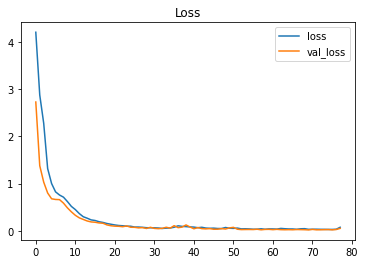

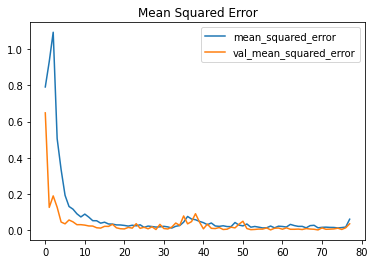

In [22]:
# Convert the Training History to a Dataframe
history_df = pd.DataFrame(History.history)
#Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.title('Loss')
plt.show()
history_df.loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot()
plt.title('Mean Squared Error')
plt.show()

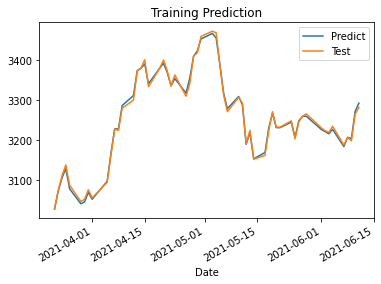

In [23]:
Results = pd.DataFrame(DL_Model.predict(test)*train_std['Close'] + train_mean['Close'])
Results.columns = ['Predict']
Results['Test'] = (list(test)[0][1])*train_std['Close'] + train_mean['Close']
Results.index = test_time[sequence_length-1:]
Results.plot()
plt.title('Training Prediction')
plt.show()

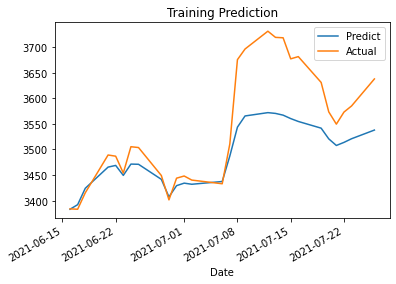

In [24]:
Results = pd.DataFrame(DL_Model.predict(actual)*train_std['Close'] + train_mean['Close'])
Results.columns = ['Predict']
Results['Actual'] = (list(actual)[0][1])*train_std['Close'] + train_mean['Close']
Results.index = actual_time[sequence_length-1:]
Results.plot()
plt.title('Training Prediction')
plt.show()

# Simulation

In [25]:
def simulation(iteration):
    
    neuron_df = df.copy()
    neuron_df.index = df.index

    # Train Test Actual Split
    portion = np.linspace(0, len(df), 10).round().astype(int)

    # Split 7:2:1
    train = neuron_df[:portion[6]]
    train_time = train.index

    test = neuron_df[portion[6]:portion[8]]
    test_time = test.index

    actual = neuron_df[portion[8]:]
    actual_time = actual.index

    # Data Normalization 
    train_std = train.std()
    train_mean = train.mean()
    train = (train - train_mean)/train_std
    test = (test - train_mean)/train_std
    actual = (actual - train_mean)/train_std

    print(train.shape, test.shape, actual.shape)
    
    #Define Sequence Lenght
    sequence_length = 4

    train = tf.keras.preprocessing.timeseries_dataset_from_array(train, 
                                                                 train['Close'], 
                                                                 sequence_length = sequence_length)

    test = tf.keras.preprocessing.timeseries_dataset_from_array(test, 
                                                                test['Close'], 
                                                                sequence_length = sequence_length)

    actual = tf.keras.preprocessing.timeseries_dataset_from_array(actual, 
                                                                  actual['Close'], 
                                                                  sequence_length = sequence_length)
    
    
    eearly_stopping = keras.callbacks.EarlyStopping(
        min_delta=0.01, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    #Defining Neural Model
    DL_Model =  keras.Sequential([
        keras.layers.LSTM(256, activation = 'tanh', return_sequences=True, kernel_regularizer='l2', recurrent_activation = 'sigmoid'),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(128, kernel_regularizer='l2'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1),
    ])

    #Compile Model Fit
    DL_Model.compile(
        optimizer= keras.optimizers.Adam(learning_rate = 0.01),
        loss=['mean_squared_error'],
        metrics = ['mean_squared_error']
    )
    
    #Record The Epoch 
    with tf.device('GPU'):
        DL_Model.fit(
            train,
            validation_data=(test),
            callbacks =early_stopping,
            batch_size=32,
            epochs=1000,
            verbose=0,
        )
    
    Records = []
    
    for num in range(iteration):

        #Record The Epoch 
        DL_Model.fit(
            train,
            validation_data=(test),
            callbacks =early_stopping,
            batch_size=32,
            epochs=1000,
            verbose=0,
        )
    
        Records.append((DL_Model.predict(actual)[-1]*train_std['Close'] + train_mean['Close'])[0])
        
        if num in np.linspace(1, iteration, 10).round():
            print(num)
    
    return Records

In [26]:
%%time

pd.options.mode.chained_assignment = None

Predict_List = simulation(100)
Predict_List

(180, 12) (60, 12) (30, 12)
1
12
23
34
45
56
67
78
89
Wall time: 7min 12s


[3505.8342878220365,
 3498.304131567109,
 3514.8973780709966,
 3532.9000985544744,
 3501.5130661318567,
 3514.621144302575,
 3521.9973282122364,
 3524.193305799363,
 3525.907118738409,
 3525.5510157887484,
 3503.006702450995,
 3517.6894969444347,
 3560.054339308398,
 3545.10471109464,
 3519.4498145753187,
 3521.322546482133,
 3503.8307357887825,
 3521.0097055271167,
 3524.80530454869,
 3533.411043601073,
 3543.4060236714186,
 3511.991525971732,
 3517.027973276245,
 3515.6206293750706,
 3518.421828282647,
 3543.0698578308943,
 3536.8788778622315,
 3511.944874739803,
 3532.144697627935,
 3519.2911847461473,
 3527.19693394905,
 3492.3166103003387,
 3526.3525256908206,
 3504.298917435225,
 3518.3341084652534,
 3526.0078305268,
 3519.590600830892,
 3538.0228601461636,
 3559.5604687911678,
 3463.850552932382,
 3526.618372846826,
 3516.8593675389957,
 3526.0746031095455,
 3538.5958523550235,
 3526.2712291152884,
 3539.33364940002,
 3518.7342435874048,
 3560.421881119226,
 3540.4650174988174,


In [27]:
#Check Distribution
STD = np.array(Predict_List).std()
Mean = np.array(Predict_List).mean()
Up_Q = np.quantile(np.array(Predict_List), .75)
Median = np.quantile(np.array(Predict_List), .5)
Low_Q = np.quantile(np.array(Predict_List), .25)

print('Prediction STD:', STD)
print('Prediction Mean:', Mean)
print('Prediction Upper Quantile:', Up_Q)
print('Prediction Median:', Median)
print('Prediction Lower Quantile:', Low_Q)

Prediction STD: 17.3527523435533
Prediction Mean: 3526.56064678646
Prediction Upper Quantile: 3537.6587212997892
Prediction Median: 3524.450288756476
Prediction Lower Quantile: 3517.380429195868


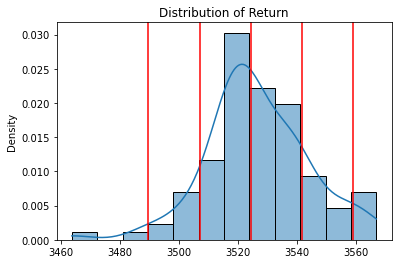

In [28]:
sns.histplot(data=Predict_List,stat = 'density', kde=True)
plt.axvline(Median,color = 'Red')
plt.axvline(Median + STD ,color = 'Red')
plt.axvline(Median - STD ,color = 'Red')
plt.axvline(Median + STD*2,color = 'Red')
plt.axvline(Median - STD*2,color = 'Red')
plt.title('Distribution of Return')
plt.show()

In [29]:
#Prediction Projection
from dateutil.relativedelta import relativedelta
Projection = pd.DataFrame({'Permessistic': df['Close'],
                           'Neutral': df['Close'],
                           'Optimistic': df['Close']
                          })
Predict_Projection = pd.DataFrame({'Permessistic': [Low_Q],
                                   'Neutral': [Median],
                                   'Optimistic': [Up_Q]
                                  })
Predict_Projection.index = [max(Projection.index) + timedelta(1)]

Projection = Projection.append(Predict_Projection)
Projection.index =pd.to_datetime(Projection.index)
Projection

,Permessistic,Neutral,Optimistic
2020-06-30,2758.820068,2758.820068,2758.820068
2020-07-01,2878.699951,2878.699951,2878.699951
2020-07-02,2890.300049,2890.300049,2890.300049
2020-07-06,3057.040039,3057.040039,3057.040039
2020-07-07,3000.120117,3000.120117,3000.120117
...,...,...,...
2021-07-21,3585.199951,3585.199951,3585.199951
2021-07-22,3638.030029,3638.030029,3638.030029
2021-07-23,3656.639893,3656.639893,3656.639893
2021-07-26,3702.729980,3702.729980,3702.729980


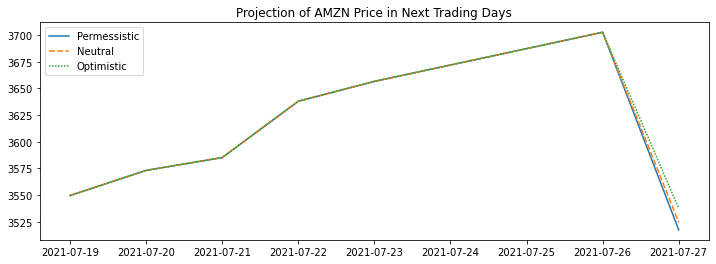

<Figure size 720x360 with 0 Axes>

In [30]:
fig = plt.figure()
fig.set_figwidth(12)
sns.lineplot(data = Projection[-7:])
plt.title(f'Projection of {tickers} Price in Next Trading Days')
plt.figure(figsize=(10, 5))
plt.show()